# 군집 분석(Cluster Analysis)

* 군집 분석은 데이터의 특성에 따라 유사한 것끼리 묶음
* 유사성을 기반으로 군집을 분류하고, 군집에 따라 유형별 특징을 분석하는 기법
* 텍스트에 대한 군집 분석에서는 군집으로 묶여진 텍스트들끼리는 최대한 유사하고, 다른 군집으로 묶여진 텍스트들과는 최대한 유사하지 않도록 분류

## 문서 유사도 측정

* 문서와 문서 간의 유사도 비교를 위해 유클리드 거리, 자카드 유사도 그리고 코사인 유사도 계산

In [12]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer  # feature 추출 시 vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer  # feature 추출 시 vectorizing
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [22]:
d1 = 'Think like a man of action and act like a man of thought'
d2 = 'Try not to become a man of success but rather try to become a man of value'
d3 = 'Give me liberty, or give me death a a of value'

corpus = [d1, d2, d3]
print(corpus)

['Think like a man of action and act like a man of thought', 'Try not to become a man of success but rather try to become a man of value', 'Give me liberty, or give me death a a of value']


In [3]:
import pandas as pd

vector = CountVectorizer(stop_words='english')
bow = vector.fit_transform(corpus)

columns = []
for k, v in sorted(vector.vocabulary_.items(), key=lambda item: item[1]):
    columns.append(k)
df = pd.DataFrame(bow.toarray(), columns=columns)
df

,act,action,death,liberty,like,man,success,think,thought,try,value
0,1,1,0,0,2,2,0,1,1,0,0
1,0,0,0,0,0,2,1,0,0,2,1
2,0,0,1,1,0,0,0,0,0,0,0


### 유클리드 거리(Euclidean distance)

* 다차원 공간에서 두개의 점 $p$와 $q$ 사이의 거리를 계산하는 방법

$$ \sqrt{\sum_{i=1}^{n}\left (q_i - p_i \right)^2} $$


In [4]:
import numpy as np
def eu_dist(p,q):
    return np.sqrt(np.sum((q-p)**2))

In [9]:
print(eu_dist(bow[0].toarray(), bow[1].toarray()))
print(eu_dist(bow[0].toarray(), bow[2].toarray()))
print(eu_dist(bow[1].toarray(), bow[2].toarray()))

3.7416573867739413
3.7416573867739413
3.4641016151377544


### 자카드 유사도(Jaccard Similarity)

* 두 텍스트 문서 사이에 공통된 용어의 수와 해당 텍스트에 존재하는 총 고유 용어 수의 비율을 사용

$$ jaccard(A, B)=\frac{\left | A\cap B \right |}{\left | A\cup B \right |}=\frac{\left | A\cap B \right |}{\left | A \left |+ \right | B \right | - \left | A\cap B \right |} $$


In [23]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

def jaccard_sim(d1, d2):
    lemmatizer = WordNetLemmatizer()  # 표제어 추출

    words1 = [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(d1)]
    words2 = [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(d2)]

    inter = len(set(words1).intersection(set(words2)))
    union = len(set(words1).union(set(words2)))
    # print(inter, union)

    return inter/union

In [24]:
print(jaccard_sim(d1,d2))
print(jaccard_sim(d1,d3))
print(jaccard_sim(d2,d3))

0.17647058823529413
0.125
0.17647058823529413


### 코사인 유사도(Cosine Similarity)

* 백터 표현 사이의 각도에 대한 코사인 값을 사용. BoW와 TF-IDF 행렬은 텍스트에 대한 백터 표현으로 활용 가능

$$ cosine(A, B)=\frac{A \cdot B}{\left \| A \right \| \left \| B \right \|}=\frac{\sum_{i=1}^{N}A_i\times B_i}{\sqrt{\sum_{i=1}^{N}\left (A_i \right)^2}\times \sqrt{\sum_{i=1}^{N}\left (B_i \right)^2}} $$

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer  # feature 추출 시 vectorizing

tfidf = TfidfVectorizer()
tfidf_vectors = tfidf.fit_transform(corpus)

print(cosine_similarity(tfidf_vectors[0],tfidf_vectors[1]))
print(cosine_similarity(tfidf_vectors[0],tfidf_vectors[2]))
print(cosine_similarity(tfidf_vectors[1],tfidf_vectors[2]))

[[0.23098282]]
[[0.05666524]]
[[0.08203274]]


## 군집화(Clustering)

* 리뷰 데이터 다운로드 (http://archive.ics.uci.edu/ml/machine-learning-databases/opinion/OpinosisDataset1.0.zip)

In [26]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/opinion/OpinosisDataset1.0.zip

--2022-10-20 11:45:11--  http://archive.ics.uci.edu/ml/machine-learning-databases/opinion/OpinosisDataset1.0.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773840 (756K) [application/x-httpd-php]
Saving to: ‘OpinosisDataset1.0.zip’

OpinosisDataset1.0. 100%[===================>] 755.70K  1.73MB/s    in 0.4s    

2022-10-20 11:45:12 (1.73 MB/s) - ‘OpinosisDataset1.0.zip’ saved [773840/773840]



In [27]:
!unzip OpinosisDataset1.0.zip

Archive:  OpinosisDataset1.0.zip
   creating: OpinosisDataset1.0/examples/
   creating: OpinosisDataset1.0/examples/prepare4rouge/
   creating: OpinosisDataset1.0/examples/prepare4rouge/input/
   creating: OpinosisDataset1.0/examples/prepare4rouge/input/summaries-base/
  inflating: OpinosisDataset1.0/examples/prepare4rouge/input/summaries-base/accuracy_garmin_nuvi_255W_gps.baseline  
  inflating: OpinosisDataset1.0/examples/prepare4rouge/input/summaries-base/bathroom_bestwestern_hotel_sfo.baseline  
   creating: OpinosisDataset1.0/examples/prepare4rouge/input/summaries-gold/
   creating: OpinosisDataset1.0/examples/prepare4rouge/input/summaries-gold/accuracy_garmin_nuvi_255W_gps/
  inflating: OpinosisDataset1.0/examples/prepare4rouge/input/summaries-gold/accuracy_garmin_nuvi_255W_gps/accuracy_garmin_nuvi_255W_gps.1.gold  
  inflating: OpinosisDataset1.0/examples/prepare4rouge/input/summaries-gold/accuracy_garmin_nuvi_255W_gps/accuracy_garmin_nuvi_255W_gps.2.gold  
 extracting: Opinosis

In [28]:
!ls OpinosisDataset1.0/topics

accuracy_garmin_nuvi_255W_gps.txt.data
bathroom_bestwestern_hotel_sfo.txt.data
battery-life_amazon_kindle.txt.data
battery-life_ipod_nano_8gb.txt.data
battery-life_netbook_1005ha.txt.data
buttons_amazon_kindle.txt.data
comfort_honda_accord_2008.txt.data
comfort_toyota_camry_2007.txt.data
directions_garmin_nuvi_255W_gps.txt.data
display_garmin_nuvi_255W_gps.txt.data
eyesight-issues_amazon_kindle.txt.data
features_windows7.txt.data
fonts_amazon_kindle.txt.data
food_holiday_inn_london.txt.data
food_swissotel_chicago.txt.data
free_bestwestern_hotel_sfo.txt.data
gas_mileage_toyota_camry_2007.txt.data
interior_honda_accord_2008.txt.data
interior_toyota_camry_2007.txt.data
keyboard_netbook_1005ha.txt.data
location_bestwestern_hotel_sfo.txt.data
location_holiday_inn_london.txt.data
mileage_honda_accord_2008.txt.data
navigation_amazon_kindle.txt.data
parking_bestwestern_hotel_sfo.txt.data
performance_honda_accord_2008.txt.data
performance_netbook_1005ha.txt.data
price_amazon_kindle.txt.data
pri

In [37]:
type(df.to_string())

str

In [40]:
import pandas as pd
import glob, os

path = r'./OpinosisDataset1.0/topics/'
files = glob.glob(os.path.join(path, '*data'))
filenames = []
opinions = []

for file_ in files:
    # print(file_)
    filename = file_.split('/')[-1]
    filename = filename.split('.')[0]
    filenames.append(filename)

    df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    # print(df)
    opinions.append(df.to_string())

opinion_df = pd.DataFrame({'filename':filenames, 'opinion':opinions})
opinion_df


,filename,opinion
0,service_holiday_inn_london,...
1,room_holiday_inn_london,...
2,video_ipod_nano_8gb,...
3,speed_windows7,...
4,directions_garmin_nuvi_255W_gps,...
5,updates_garmin_nuvi_255W_gps,...
6,price_holiday_inn_london,...
7,features_windows7,...
8,buttons_amazon_kindle,...
9,interior_honda_accord_2008,...


In [55]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer  # feature 추출 시 vectorizing

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.05, max_df=0.85)  # 1-gram & 2-gram / 0.05보다 작은 것 무시, 0.85보다 큰 것 무시
tfidf_vectors = tfidf.fit_transform(opinion_df['opinion'])
feature_names = tfidf.get_feature_names_out()

print(feature_names)
print(len(feature_names))


['00' '000' '000 miles' ... 'yes rooms' 'yields' 'zoom']
4400


### DBSCAN 알고리즘

* 밀도 기반의 군집화 알고리즘
* 특정 벡터부터 시작해 반경내 기준치 만큼의 점들이 존재한다면 군집화 하는 방식
* 일정 밀도 이상의 데이터를 기준으로 군집을 형성하기 때문에 노이즈 처리에 용이
* 이미 형성된 군집 기준으로 기준점을 옮겨가며 처리하기 때문에 분포가 이상한 데이터에도 강건함
* K-means에 비해 속도가 느리고, 파라미터 값인 epsilon, min_sampels 값에 영향을 많이 받음

In [42]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.7, min_samples=3, metric='cosine')
dbscan_label = dbscan.fit_predict(tfidf_vectors)
print(dbscan_label)

[ 0  0  3 -1 -1 -1  0 -1 -1  1  3 -1  0  0  2  0 -1  3 -1  0 -1 -1  0  3
  0  1 -1  3  0  2 -1 -1 -1 -1  1  3  0 -1  1  2  1 -1 -1  2 -1  0  3  3
  0  2  3]


In [43]:
opinion_df['cluster'] = dbscan_label
opinion_df

,filename,opinion,cluster
0,service_holiday_inn_london,...,0
1,room_holiday_inn_london,...,0
2,video_ipod_nano_8gb,...,3
3,speed_windows7,...,-1
4,directions_garmin_nuvi_255W_gps,...,-1
5,updates_garmin_nuvi_255W_gps,...,-1
6,price_holiday_inn_london,...,0
7,features_windows7,...,-1
8,buttons_amazon_kindle,...,-1
9,interior_honda_accord_2008,...,1


In [44]:
for cluster_num in set(dbscan_label):
    print('Cluster : {}'.format(cluster_num))
    df = opinion_df[opinion_df['cluster'] == cluster_num]
    for filename in df['filename']:
        print(filename)
    print() 


Cluster : 0
service_holiday_inn_london
room_holiday_inn_london
price_holiday_inn_london
food_holiday_inn_london
rooms_swissotel_chicago
food_swissotel_chicago
bathroom_bestwestern_hotel_sfo
service_swissotel_hotel_chicago
service_bestwestern_hotel_sfo
location_holiday_inn_london
rooms_bestwestern_hotel_sfo
price_amazon_kindle
location_bestwestern_hotel_sfo

Cluster : 1
interior_honda_accord_2008
comfort_honda_accord_2008
seats_honda_accord_2008
interior_toyota_camry_2007
comfort_toyota_camry_2007

Cluster : 2
performance_netbook_1005ha
battery-life_amazon_kindle
performance_honda_accord_2008
battery-life_ipod_nano_8gb
battery-life_netbook_1005ha

Cluster : 3
video_ipod_nano_8gb
voice_garmin_nuvi_255W_gps
speed_garmin_nuvi_255W_gps
size_asus_netbook_1005ha
keyboard_netbook_1005ha
screen_ipod_nano_8gb
screen_garmin_nuvi_255W_gps
screen_netbook_1005ha
display_garmin_nuvi_255W_gps

Cluster : -1
speed_windows7
directions_garmin_nuvi_255W_gps
updates_garmin_nuvi_255W_gps
features_windows7
bu

### K-means 알고리즘

* 대표적인 군집화 알고리즘
* 클러스터 수 k를 직접 지정해야 함
* 각 군집내 평균 벡터와 해당 군집에 속한 벡터간의 거리 제곱의 합이 최소가 되는 군집을 찾는 방법
* 노이즈 데이터에 취약하고, 중심점(centroid)을 임의로 잡기 때문에 군집 결과가 상이하거나 나쁠수 있음

In [47]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, max_iter=10000, random_state=1)
kmeans_label = kmeans.fit_predict(tfidf_vectors)
kmeans_centers = kmeans.cluster_centers_

print(kmeans_label)
pd.DataFrame(kmeans_centers)  # column이 차원

[0 0 1 1 1 1 0 1 1 2 1 1 0 0 1 0 2 1 0 0 2 2 0 1 0 2 0 1 0 1 1 2 1 1 2 1 0
 1 2 2 2 0 0 1 1 1 1 1 0 1 1]


,0,1,2,3,4,5,6,7,8,9,...,4390,4391,4392,4393,4394,4395,4396,4397,4398,4399
0,0.004467,0.000000,0.00000,0.000000,0.000195,0.000000,0.000000,0.000857,0.001729,0.000000,...,0.001365,0.001024,0.002556,0.000865,0.000700,0.000951,0.003261,0.001657,0.000000,0.000000
1,0.001304,0.000000,0.00000,0.000000,0.000000,0.000551,0.000000,0.000000,0.000000,0.003177,...,0.005709,0.003491,0.005241,0.002440,0.001774,0.000000,0.002975,0.000000,0.000411,0.007339
2,0.000932,0.007161,0.00486,0.003372,0.003252,0.004269,0.007004,0.000000,0.000000,0.000000,...,0.004123,0.002509,0.005445,0.000000,0.000000,0.002379,0.001887,0.000000,0.002924,0.000000


In [49]:
opinion_df['cluster'] = kmeans_label
opinion_df

,filename,opinion,cluster
0,service_holiday_inn_london,...,0
1,room_holiday_inn_london,...,0
2,video_ipod_nano_8gb,...,1
3,speed_windows7,...,1
4,directions_garmin_nuvi_255W_gps,...,1
5,updates_garmin_nuvi_255W_gps,...,1
6,price_holiday_inn_london,...,0
7,features_windows7,...,1
8,buttons_amazon_kindle,...,1
9,interior_honda_accord_2008,...,2


In [50]:
for cluster_num in set(kmeans_label):
    print('Cluster : {}'.format(cluster_num))
    df = opinion_df[opinion_df['cluster'] == cluster_num]
    for filename in df['filename']:
        print(filename)
    print() 


Cluster : 0
service_holiday_inn_london
room_holiday_inn_london
price_holiday_inn_london
food_holiday_inn_london
rooms_swissotel_chicago
food_swissotel_chicago
parking_bestwestern_hotel_sfo
bathroom_bestwestern_hotel_sfo
service_swissotel_hotel_chicago
service_bestwestern_hotel_sfo
staff_bestwestern_hotel_sfo
location_holiday_inn_london
rooms_bestwestern_hotel_sfo
staff_swissotel_chicago
free_bestwestern_hotel_sfo
location_bestwestern_hotel_sfo

Cluster : 1
video_ipod_nano_8gb
speed_windows7
directions_garmin_nuvi_255W_gps
updates_garmin_nuvi_255W_gps
features_windows7
buttons_amazon_kindle
voice_garmin_nuvi_255W_gps
accuracy_garmin_nuvi_255W_gps
performance_netbook_1005ha
speed_garmin_nuvi_255W_gps
size_asus_netbook_1005ha
keyboard_netbook_1005ha
battery-life_amazon_kindle
satellite_garmin_nuvi_255W_gps
sound_ipod_nano_8gb
navigation_amazon_kindle
screen_ipod_nano_8gb
fonts_amazon_kindle
battery-life_ipod_nano_8gb
eyesight-issues_amazon_kindle
price_amazon_kindle
screen_garmin_nuvi_255

In [58]:
print(kmeans_centers.argsort()[:, ::-1])
print(feature_names[1993])

[[1993 3548 3390 ... 2212 2213 2199]
 [3471  602  608 ... 3619 3136 1131]
 [2135 2594 3514 ... 1987 1986 4399]]
hotel


In [54]:
# cluster label
# cluster에 들어가는 file명
# cluster의 핵심 feature (cluster의 centroid 좌표 중 값이 큰 것들) 
## -> 이렇게 해석할 수 있는 이유는 , tfidf 자체가 각 좌표별로 1개의 단어에 대해서, 값이 클 수록, 그 단어의 중요도가 큰 것이기 때문
## -> 그래서, centroid의 좌표가 크다는 것은, 그 좌표에 해당하는 단어가 많이 나온다는 것

centroid_feature = kmeans_centers.argsort()[:, ::-1]  # 배열값이 큰 값 index 순으로

for cluster_num in set(kmeans_label):
    print('Cluster : {}'.format(cluster_num))

    df = opinion_df[opinion_df['cluster'] == cluster_num]
    print(df['filename'].tolist())
    
    top_feature_index = centroid_feature[cluster_num, :10] 
    top_features = [feature_names[i] for i in top_feature_index]
    print(top_features)

    top_feature_values = kmeans_centers[cluster_num, top_feature_index].tolist()
    print(top_feature_values)
    print()

Cluster : 0
['service_holiday_inn_london', 'room_holiday_inn_london', 'price_holiday_inn_london', 'food_holiday_inn_london', 'rooms_swissotel_chicago', 'food_swissotel_chicago', 'parking_bestwestern_hotel_sfo', 'bathroom_bestwestern_hotel_sfo', 'service_swissotel_hotel_chicago', 'service_bestwestern_hotel_sfo', 'staff_bestwestern_hotel_sfo', 'location_holiday_inn_london', 'rooms_bestwestern_hotel_sfo', 'staff_swissotel_chicago', 'free_bestwestern_hotel_sfo', 'location_bestwestern_hotel_sfo']
['hotel', 'service', 'rooms', 'staff', 'room', 'food', 'location', 'clean', 'bathroom', 'parking']
[0.18594575243038408, 0.18328248541586756, 0.16375847485211506, 0.15209008635937118, 0.1472675309494923, 0.12972287464448046, 0.12743016012771918, 0.0719182342974076, 0.06973548911159087, 0.06000673271289662]

Cluster : 1
['video_ipod_nano_8gb', 'speed_windows7', 'directions_garmin_nuvi_255W_gps', 'updates_garmin_nuvi_255W_gps', 'features_windows7', 'buttons_amazon_kindle', 'voice_garmin_nuvi_255W_gps

In [66]:
print(tfidf_vectors)

  (0, 3241)	0.007633342467938747
  (0, 583)	0.008757174173621818
  (0, 1999)	0.008757174173621818
  (0, 2410)	0.008329913188698157
  (0, 1483)	0.008757174173621818
  (0, 699)	0.009262516660699356
  (0, 1066)	0.009262516660699356
  (0, 1550)	0.009881005879304888
  (0, 4222)	0.009881005879304888
  (0, 3466)	0.009881005879304888
  (0, 513)	0.009881005879304888
  (0, 2717)	0.009262516660699356
  (0, 653)	0.009881005879304888
  (0, 3697)	0.008329913188698157
  (0, 3404)	0.007959802888860914
  (0, 919)	0.007077141489230424
  (0, 3793)	0.008757174173621818
  (0, 1953)	0.008329913188698157
  (0, 3086)	0.009881005879304888
  (0, 4047)	0.009881005879304888
  (0, 2189)	0.009262516660699356
  (0, 2012)	0.009881005879304888
  (0, 87)	0.009881005879304888
  (0, 3572)	0.008757174173621818
  (0, 2630)	0.009881005879304888
  :	:
  (50, 1556)	0.02173416696340283
  (50, 3344)	0.042019105284916904
  (50, 3729)	0.01802267688674191
  (50, 1271)	0.037113128997338686
  (50, 1128)	0.01704833005443523
  (50, 33

In [67]:
# 51개 data(row)가 있고, 각 row는 4400개의 column(단어개수)를 가짐

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=1)
pca_vecs = pca.fit_transform(tfidf_vectors.toarray())
opinion_df['x0'] = pca_vecs[:,0]
opinion_df['x1'] = pca_vecs[:,1]
print(pca_vecs.shape)
# print(pca_vecs)

cluster_map = {0:'Accommodation', 1:'Electronic device', 2 : 'Car'}
opinion_df['cluster'] = opinion_df['cluster'].map(cluster_map)  # column 값 변경
opinion_df

(51, 2)


,filename,opinion,cluster,x0,x1
0,service_holiday_inn_london,...,Accommodation,0.633664,-0.152777
1,room_holiday_inn_london,...,Accommodation,0.416224,-0.071432
2,video_ipod_nano_8gb,...,Electronic device,-0.151987,-0.070987
3,speed_windows7,...,Electronic device,-0.087091,0.005382
4,directions_garmin_nuvi_255W_gps,...,Electronic device,-0.114060,-0.015699
5,updates_garmin_nuvi_255W_gps,...,Electronic device,-0.109129,-0.022577
6,price_holiday_inn_london,...,Accommodation,0.320337,-0.065965
7,features_windows7,...,Electronic device,-0.103828,0.005736
8,buttons_amazon_kindle,...,Electronic device,-0.137907,-0.057989
9,interior_honda_accord_2008,...,Car,-0.106102,0.513066


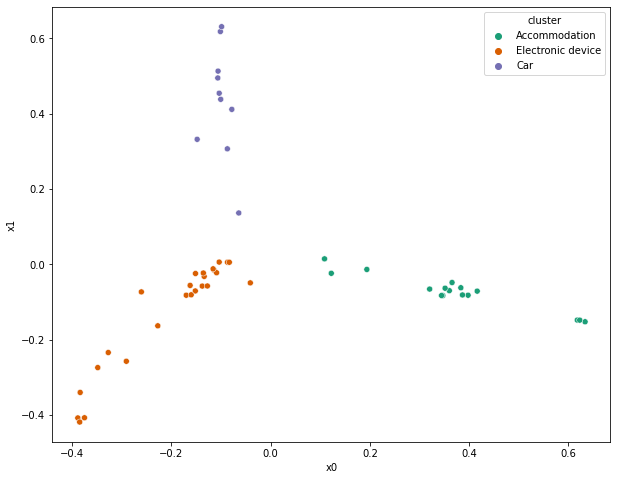

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.xlabel('x0')
plt.ylabel('x1')
sns.scatterplot(data=opinion_df, x='x0', y='x1', hue='cluster', palette='Dark2')

### 리뷰 문서 유사도 측정

In [73]:
# 아래 셀에 참고
tfidf.vocabulary_.items()

dict_items([('customer', 1158), ('oriented', 2823), ('low', 2488), ('service', 3548), ('reception', 3234), ('room', 3357), ('quiet', 3145), ('clean', 898), ('bed', 618), ('pillows', 2940), ('comfortable', 984), ('adequate', 427), ('issues', 2172), ('speak', 3751), ('overly', 2841), ('friendly', 1688), ('hotel', 1993), ('location', 2396), ('horrible', 1989), ('disgusting', 1287), ('procedures', 3077), ('looking', 2449), ('experience', 1496), ('holiday', 1979), ('inn', 2113), ('kensington', 2215), ('forum', 1666), ('fine', 1605), ('large', 2267), ('hotels', 2029), ('mediocre', 2562), ('breakfast', 728), ('rooms', 3390), ('don', 1313), ('mind', 2604), ('tired', 4021), ('decor', 1200), ('desk', 1232), ('indifferent', 2101), ('stay', 3848), ('prompt', 3092), ('area', 512), ('deposit', 1223), ('offered', 2787), ('upgrade', 4151), ('executive', 1482), ('extra', 1510), ('cost', 1115), ('london', 2428), ('hard', 1915), ('place', 2943), ('did', 1245), ('couldn', 1120), ('ask', 527), ('choices', 

In [70]:
# filename x words Matrix 만들기
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer  # feature 추출 시 vectorizing
import pandas as pd

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.05, max_df=0.85)  # 1-gram & 2-gram / 0.05보다 작은 것 무시, 0.85보다 큰 것 무시
tfidf_vectors = tfidf.fit_transform(opinion_df['opinion'])

word_id_list = sorted(tfidf.vocabulary_.items(), key=lambda x:x[1], reverse=False)  # index가 작은 것이 앞에 가도록 정렬하는 것!
word_list = [x[0] for x in word_id_list]

tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=word_list, index=opinion_df['filename'])
tfidf_df


,00,000,000 miles,05,06,07,08,10 did,10 great,10 inch,...,year,year old,years,years ago,years old,yellow,yes,yes rooms,yields,zoom
filename,,,,,,,,,,,,,,,,,,,,,
service_holiday_inn_london,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
room_holiday_inn_london,0.007154,0.000000,0.000000,0.000000,0.003121,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001656,0.002682,0.000000,0.006659,0.012208,0.009363,0.000000,0.000000
video_ipod_nano_8gb,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.014481,0.007305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
speed_windows7,0.000000,0.000000,0.000000,0.000000,0.000000,0.013773,0.000000,0.000000,0.000000,0.000000,...,0.008060,0.010165,0.000000,0.000000,0.000000,0.000000,0.017959,0.000000,0.000000,0.000000
directions_garmin_nuvi_255W_gps,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.014055,0.011381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
updates_garmin_nuvi_255W_gps,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011538,0.000000,0.010463,0.016945,0.000000,0.000000,0.000000,0.000000,0.000000,0.017733
price_holiday_inn_london,0.017464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.006064,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
features_windows7,0.019117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.026552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
buttons_amazon_kindle,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005497,0.000000,0.000000,0.000000


In [77]:
# 코사인 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

cos_sim_df = pd.DataFrame(cosine_similarity(tfidf_df,tfidf_df), columns=opinion_df['filename'], index=opinion_df['filename'])
cos_sim_df

filename,service_holiday_inn_london,room_holiday_inn_london,video_ipod_nano_8gb,speed_windows7,directions_garmin_nuvi_255W_gps,updates_garmin_nuvi_255W_gps,price_holiday_inn_london,features_windows7,buttons_amazon_kindle,interior_honda_accord_2008,...,staff_swissotel_chicago,free_bestwestern_hotel_sfo,battery-life_ipod_nano_8gb,eyesight-issues_amazon_kindle,price_amazon_kindle,screen_garmin_nuvi_255W_gps,screen_netbook_1005ha,location_bestwestern_hotel_sfo,battery-life_netbook_1005ha,display_garmin_nuvi_255W_gps
filename,,,,,,,,,,,,,,,,,,,,,
service_holiday_inn_london,1.000000,0.397605,0.013016,0.025717,0.024181,0.011755,0.277467,0.015353,0.014483,0.022680,...,0.236193,0.095314,0.011445,0.012767,0.038094,0.018686,0.019865,0.217927,0.017474,0.017195
room_holiday_inn_london,0.397605,1.000000,0.018945,0.029817,0.020320,0.021138,0.315732,0.023414,0.024927,0.041024,...,0.199239,0.111220,0.011041,0.021637,0.039555,0.021537,0.042053,0.156884,0.021583,0.019680
video_ipod_nano_8gb,0.013016,0.018945,1.000000,0.033821,0.020527,0.016307,0.015558,0.047699,0.021995,0.015818,...,0.006321,0.005692,0.165513,0.024236,0.023158,0.046433,0.064163,0.008996,0.036727,0.016573
speed_windows7,0.025717,0.029817,0.033821,1.000000,0.029254,0.030612,0.018028,0.233244,0.033484,0.021248,...,0.014621,0.015698,0.024695,0.025990,0.031501,0.026302,0.057921,0.009018,0.039573,0.022519
directions_garmin_nuvi_255W_gps,0.024181,0.020320,0.020527,0.029254,1.000000,0.150799,0.031581,0.047840,0.038943,0.015753,...,0.015400,0.009245,0.022931,0.038851,0.023734,0.229593,0.057725,0.035071,0.014993,0.142169
updates_garmin_nuvi_255W_gps,0.011755,0.021138,0.016307,0.030612,0.150799,1.000000,0.016475,0.030298,0.022968,0.007603,...,0.006458,0.069374,0.015535,0.032066,0.031283,0.179234,0.059041,0.010750,0.023671,0.203082
price_holiday_inn_london,0.277467,0.315732,0.015558,0.018028,0.031581,0.016475,1.000000,0.016636,0.014282,0.013830,...,0.138231,0.092061,0.022335,0.012390,0.441708,0.017698,0.023499,0.300445,0.016010,0.015391
features_windows7,0.015353,0.023414,0.047699,0.233244,0.047840,0.030298,0.016636,1.000000,0.026492,0.036438,...,0.011319,0.011970,0.030700,0.025960,0.034259,0.065869,0.062871,0.006988,0.030558,0.045460
buttons_amazon_kindle,0.014483,0.024927,0.021995,0.033484,0.038943,0.022968,0.014282,0.026492,1.000000,0.020531,...,0.009760,0.011085,0.024574,0.151591,0.156151,0.102640,0.085935,0.012200,0.023913,0.066709


In [96]:
# 군집 0:'Accommodation', 1:'Electronic device', 2 : 'Car'

from sklearn.metrics.pairwise import cosine_similarity

hotel_index = opinion_df[opinion_df['cluster']=='Accommodation'].index
print(hotel_index)

# hotel_index[0]에 해당하는 호텔만 가져옴
hotel_file_name = opinion_df.iloc[hotel_index[0]]['filename']
print(hotel_file_name)

# hotel_index[0]과 나머지 Accommodation 군집들간 유사도
hotel_similarity = cosine_similarity(tfidf_vectors[hotel_index[0]], tfidf_vectors[hotel_index])

print(hotel_similarity)

Int64Index([0, 1, 6, 12, 13, 15, 18, 19, 22, 24, 26, 28, 36, 41, 42, 48], dtype='int64')
service_holiday_inn_london
[[1.         0.39760539 0.27746678 0.32679228 0.18854619 0.33162962
  0.08328937 0.13203572 0.89411341 0.85447857 0.21211888 0.29007561
  0.18512303 0.23619253 0.09531352 0.21792723]]


In [98]:
# hotel_index[0]과 나머지의 유사도를 보는 곳

import pandas as pd

hotel_file_name = opinion_df.iloc[hotel_index]['filename']
df = pd.DataFrame({'similarity': hotel_similarity.reshape(-1)}, index=hotel_file_name)
df

,similarity
filename,
service_holiday_inn_london,1.000000
room_holiday_inn_london,0.397605
price_holiday_inn_london,0.277467
food_holiday_inn_london,0.326792
rooms_swissotel_chicago,0.188546
food_swissotel_chicago,0.331630
parking_bestwestern_hotel_sfo,0.083289
bathroom_bestwestern_hotel_sfo,0.132036
service_swissotel_hotel_chicago,0.894113


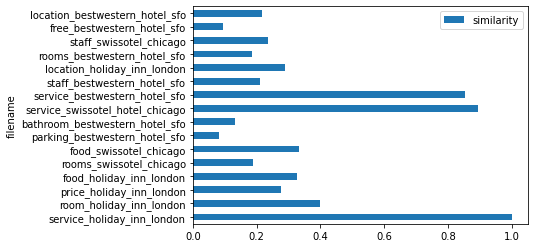

In [99]:
df.plot.barh()

## 계층적 군집화(Hierarchical Clustering)

* 계층적 군집화란 개별 개체들을 유사한 개체나 그룹과 통합해 군집화를 수행하는 알고리즘
* 비계층적 군집화와는 달리 군집 수를 지정하지 않아도 군집화를 할 수 있는 것이 장점  
* 계층적 군집화는 모든 개체간 거리나 유사도가 미리 계산되어 있어야만 하며, 계산복잡도도 비계층적 군집화보다 큼




### 병합 군집화(Agglomerative Clustering)

* 비계층적 군집화의 일종인 `agglomerativeClustering`(병합 군집)을 이용, 계층적 군집화 실습    
* 병합 군집은 각 개체들을 클러스터로 간주, 종료 조건을 만족할 때 까지 가장 비슷한 두 클러스터들을 합치며 진행
* 병합 군집의 방법으로는 3가지 이상(ward, average, complete)를 지정 가능

`ward`: 모든 클러스터 내의 분산을 가장 적게 증가시키는 두 클러스터를 합침(기본값)

In [100]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=3, linkage='ward')
predict = ward.fit_predict(tfidf_vectors.toarray())
predict

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 2,
       1, 0, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 2, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0])

In [101]:
results = opinion_df
results['predict'] = predict
results

,filename,opinion,cluster,x0,x1,predict
0,service_holiday_inn_london,...,Accommodation,0.633664,-0.152777,1
1,room_holiday_inn_london,...,Accommodation,0.416224,-0.071432,1
2,video_ipod_nano_8gb,...,Electronic device,-0.151987,-0.070987,0
3,speed_windows7,...,Electronic device,-0.087091,0.005382,0
4,directions_garmin_nuvi_255W_gps,...,Electronic device,-0.114060,-0.015699,0
5,updates_garmin_nuvi_255W_gps,...,Electronic device,-0.109129,-0.022577,0
6,price_holiday_inn_london,...,Accommodation,0.320337,-0.065965,1
7,features_windows7,...,Electronic device,-0.103828,0.005736,0
8,buttons_amazon_kindle,...,Electronic device,-0.137907,-0.057989,0
9,interior_honda_accord_2008,...,Car,-0.106102,0.513066,2


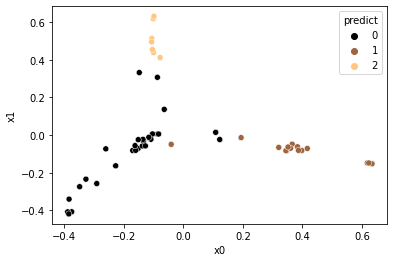

In [108]:
import seaborn as sns

sns.scatterplot(data=results, x='x0', y='x1',hue='predict', palette='copper')

`average`: 클러스터간 평균 거리가 가장 짧은 두 클러스터를 합침

`complete`: 클러스터간 최대 거리가 가장 짧은 두 클러스터를 합침

### 덴드로그램(Dendrogram)

* `pdist`를 이용한 각 단어간 유클리디안 거리 계산
    + 1차원 벡터(n(n-1)/2)로 output 생성됨
    + squareform로 nxn matrix로 만들어줘야 함

In [114]:
tfidf_vectors.toarray().shape

(51, 4400)

In [113]:
dist_matrix = pdist(tfidf_vectors.toarray(), metric='euclidean')
dist_matrix.shape # 1275 = 51 x 50 / 2

(1275,)

In [110]:
# tfidf_vectors 의 각 row들 간의 유클리드 거리 구하기!

from scipy.spatial.distance import pdist, squareform  # squreform은 nxn sym matrix 와  n(n-1)/2 x 1 matrix를 서로 양방향 교환해주는 것


dist_matrix = pdist(tfidf_vectors.toarray(), metric='euclidean')
row_dist = pd.DataFrame(squareform(dist_matrix))
row_dist

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.000000,1.097629,1.404979,1.395911,1.397010,1.405877,1.202109,1.403315,1.403935,1.398084,...,1.235967,1.345129,1.406098,1.405157,1.387015,1.400938,1.400096,1.250658,1.401803,1.402002
1,1.097629,0.000000,1.400754,1.392970,1.399771,1.399187,1.169844,1.397559,1.396476,1.384902,...,1.265512,1.333252,1.406385,1.398830,1.385962,1.398902,1.384158,1.298550,1.398869,1.400229
2,1.404979,1.400754,0.000000,1.390093,1.399623,1.402635,1.403170,1.380073,1.398574,1.402984,...,1.409737,1.410183,1.291888,1.396971,1.397742,1.380991,1.368091,1.407838,1.388001,1.402445
3,1.395911,1.392970,1.390093,0.000000,1.393374,1.392399,1.401408,1.238351,1.390335,1.399108,...,1.403837,1.403070,1.396642,1.395715,1.391761,1.395492,1.372646,1.407823,1.385949,1.398200
4,1.397010,1.399771,1.399623,1.393374,0.000000,1.303228,1.391703,1.379971,1.386403,1.403030,...,1.403282,1.407661,1.397905,1.386470,1.397330,1.241295,1.372789,1.389194,1.403572,1.309833
5,1.405877,1.399187,1.402635,1.392399,1.303228,0.000000,1.402516,1.392625,1.397879,1.408827,...,1.409640,1.364277,1.403185,1.391355,1.391918,1.281223,1.371830,1.406592,1.397375,1.262472
6,1.202109,1.169844,1.403170,1.401408,1.391703,1.402516,0.000000,1.402401,1.404079,1.404401,...,1.312836,1.347545,1.398331,1.405425,1.056685,1.401643,1.397499,1.182840,1.402847,1.403288
7,1.403315,1.397559,1.380073,1.238351,1.379971,1.392625,1.402401,0.000000,1.395355,1.388209,...,1.406187,1.405724,1.392336,1.395736,1.389777,1.366843,1.369035,1.409264,1.392438,1.381695
8,1.403935,1.396476,1.398574,1.390335,1.386403,1.397879,1.404079,1.395355,0.000000,1.399621,...,1.407296,1.406353,1.396729,1.302619,1.299114,1.339672,1.352084,1.405560,1.397202,1.366229
9,1.398084,1.384902,1.402984,1.399108,1.403030,1.408827,1.404401,1.388209,1.399621,0.000000,...,1.406999,1.410005,1.406492,1.403129,1.404516,1.396999,1.398710,1.406694,1.407475,1.403701


* 각 단어간 유클리디안 거리를 이용한 군집 분석 및 덴드로그램 시각화

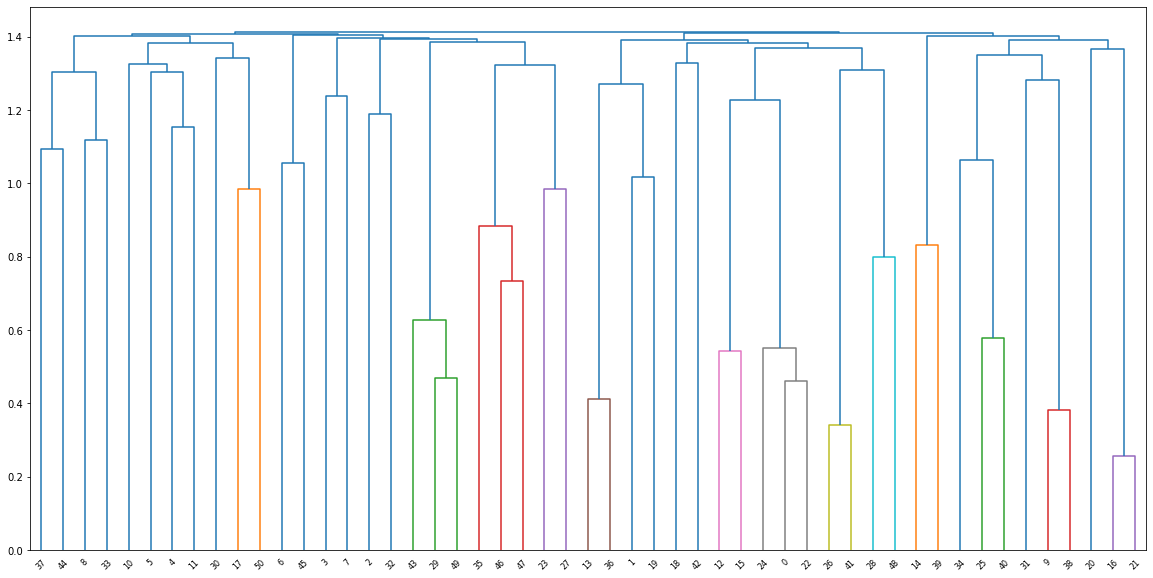

In [117]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram

row_clusters = linkage(dist_matrix, method='complete')

plt.figure(figsize=(20,10))
dendrogram(row_clusters, leaf_rotation=45, leaf_font_size=8)
plt.show()

* 각 단어간 코사인 유사도를 이용한 군집 분석 및 덴드로그램 시각화

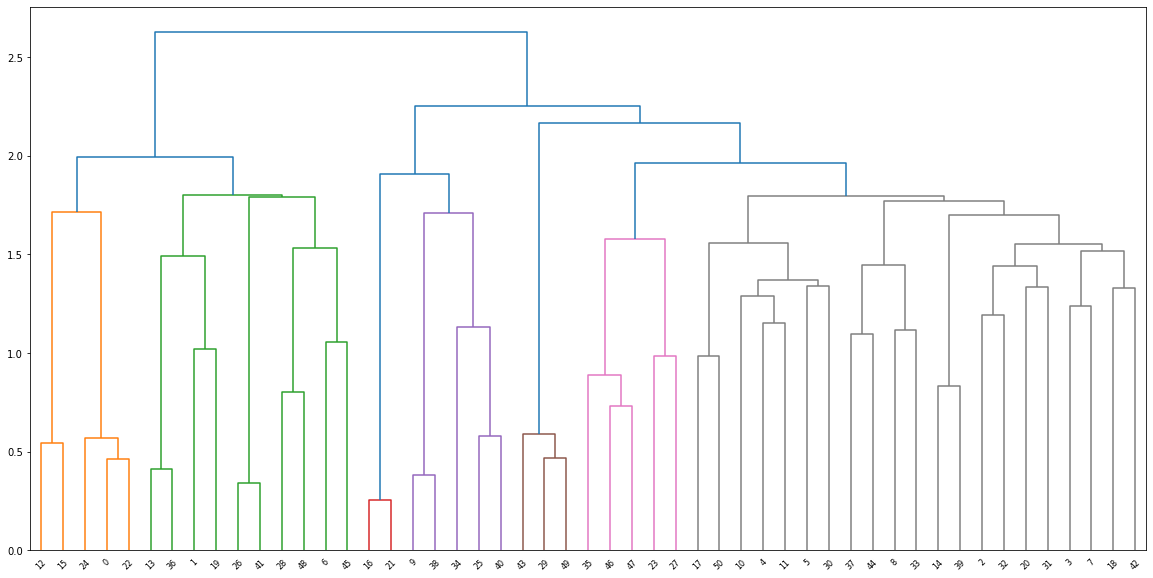

In [119]:
from scipy.spatial.distance import pdist, squareform  # squreform은 nxn sym matrix 와  n(n-1)/2 x 1 matrix를 서로 양방향 교환해주는 것


dist_matrix = pdist(tfidf_vectors.toarray(), metric='euclidean')
row_dist = pd.DataFrame(squareform(dist_matrix))


import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram

row_clusters = linkage(dist_matrix, method='ward')

plt.figure(figsize=(20,10))
dendrogram(row_clusters, leaf_rotation=45, leaf_font_size=8)
plt.show()

## 뉴스그룹 군집 분석

### 데이터 로드 및 전처리

In [120]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

news = fetch_20newsgroups(subset='train', shuffle=True, remove=('headers','footers','quotes'))
df = pd.DataFrame(news.data, columns=['corpus'])
df

,corpus
0,I was wondering if anyone out there could enli...
1,A fair number of brave souls who upgraded thei...
2,"well folks, my mac plus finally gave up the gh..."
3,\nDo you have Weitek's address/phone number? ...
4,"From article <C5owCB.n3p@world.std.com>, by to..."
...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...
11310,"I have a (very old) Mac 512k and a Mac Plus, b..."
11311,I just installed a DX2-66 CPU in a clone mothe...
11312,\nWouldn't this require a hyper-sphere. In 3-...


In [126]:
import re
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text) # 대괄호 없애기
    text = re.sub('https?://\S+|www\.\S+','', text) # https, www. 없애기
    text = re.sub('<.*?>+','',text)  # < , >없애기
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # 구두점제거
    text = re.sub('\n','', text)
    text = re.sub('\w*\d\W*','', text)  # 숫자포함단어

    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w in stopwords.words('english')]
    text = ' '.join(tokens)
    text = text.lower().strip()

    
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [127]:
df['cleaned'] = df['corpus'].apply(preprocess_text)

### K-means 군집화

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer  # feature 추출 시 vectorizing

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=0.05, max_df=0.95)  # 1-gram & 2-gram / 0.05보다 작은 것 무시, 0.85보다 큰 것 무시
x = tfidf_vectorizer.fit_transform(df['cleaned'] )
x.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19059182, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [130]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(x)

clusters = kmeans.labels_
df['cluster'] = clusters
df

,corpus,cleaned,cluster
0,I was wondering if anyone out there could enli...,wondering anyone could enlighten car sawthe da...,0
1,A fair number of brave souls who upgraded thei...,fair number brave souls upgraded si clock osci...,1
2,"well folks, my mac plus finally gave up the gh...",well folks mac plus finally gave ghost weekend...,2
3,\nDo you have Weitek's address/phone number? ...,weiteks addressphone number id like get inform...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",article tombakerworldstdcom tom bakermy unders...,1
...,...,...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,dn nyedacnsvaxuwecedu david nyedn neurologydn ...,2
11310,"I have a (very old) Mac 512k and a Mac Plus, b...",old mac k mac plus problemtheir screens blank ...,1
11311,I just installed a DX2-66 CPU in a clone mothe...,installed cpu clone motherboard tried mounting...,1
11312,\nWouldn't this require a hyper-sphere. In 3-...,wouldnt require hypersphere space points speci...,1


In [133]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=1)
pca_vecs = pca.fit_transform(x.toarray())

df['x0'] = pca_vecs[:,0]
df['x1'] = pca_vecs[:,1]

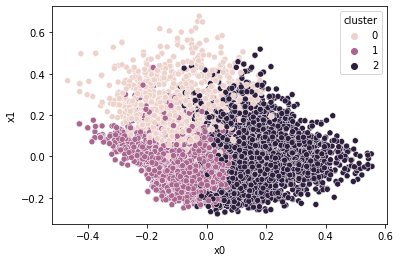

In [142]:
import seaborn as sns
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster')

In [144]:
df2 = pd.DataFrame(x.todense()).groupby(clusters).mean()
df2

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,0.010300,0.031629,0.010885,0.249835,0.024956,0.013699,0.015846,0.011674,0.012099,0.008323,...,0.027611,0.025662,0.031458,0.022782,0.011610,0.012108,0.023997,0.059862,0.005263,0.013206
1,0.012999,0.029974,0.011680,0.001735,0.009449,0.012244,0.018404,0.012881,0.015390,0.013438,...,0.024456,0.023776,0.018247,0.018368,0.022749,0.011722,0.019243,0.005061,0.017693,0.016022
2,0.020752,0.053079,0.027964,0.012708,0.021603,0.024766,0.029091,0.033723,0.021098,0.027999,...,0.032503,0.023489,0.036568,0.042298,0.046428,0.028707,0.028473,0.146521,0.023361,0.029094


In [146]:
terms = tfidf_vectorizer.get_feature_names_out()

for i, r in df2.iterrows():
    print('Cluster : {}'.format(i))
    print(', '.join( [ terms[t] for t in np.argsort(r)[-10:] ] )) # 뒤에서부터 10개 tfidf 점수 높은 것들 뽑기

Cluster : 0
help, please, email, get, like, im, would, dont, know, anyone
Cluster : 1
dont, good, email, also, like, im, please, use, new, get
Cluster : 2
even, time, also, get, think, dont, like, people, one, would


### 병합 군집화

In [149]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=5, linkage='ward')
predict = ward.fit_predict(x.toarray())

results = df
results['predict'] = predict
results

,corpus,cleaned,cluster,x0,x1,predict
0,I was wondering if anyone out there could enli...,wondering anyone could enlighten car sawthe da...,0,-0.295822,0.439470,4
1,A fair number of brave souls who upgraded thei...,fair number brave souls upgraded si clock osci...,1,-0.262221,0.005251,4
2,"well folks, my mac plus finally gave up the gh...",well folks mac plus finally gave ghost weekend...,2,0.175616,0.071594,2
3,\nDo you have Weitek's address/phone number? ...,weiteks addressphone number id like get inform...,1,-0.061262,0.093589,0
4,"From article <C5owCB.n3p@world.std.com>, by to...",article tombakerworldstdcom tom bakermy unders...,1,-0.002728,-0.082591,0
...,...,...,...,...,...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,dn nyedacnsvaxuwecedu david nyedn neurologydn ...,2,0.310476,-0.040508,2
11310,"I have a (very old) Mac 512k and a Mac Plus, b...",old mac k mac plus problemtheir screens blank ...,1,-0.100713,-0.138973,0
11311,I just installed a DX2-66 CPU in a clone mothe...,installed cpu clone motherboard tried mounting...,1,-0.088233,-0.097709,0
11312,\nWouldn't this require a hyper-sphere. In 3-...,wouldnt require hypersphere space points speci...,1,-0.055629,-0.053440,1


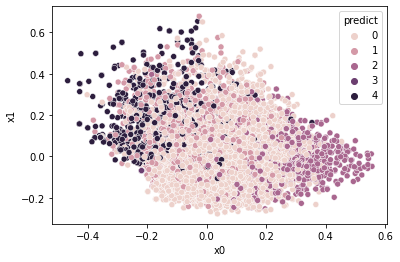

In [150]:
import seaborn as sns
sns.scatterplot(data=df, x='x0', y='x1', hue='predict')